# Brief description of the problem and data 

## 1. Challenge Overview
Build a GAN that produces 7000–10000 images (256×256 RGB) in the style of Claude Monet.

The submission is a ZIP file named `images.zip` containing between 7000 and 10000 JPEG images of size 256×256.

## 2. Data Overview

| Domain | Directory Names | Count | Format(s) | Resolution | Usage |
|--------|-----------------|-------|-----------|------------|-------|
| Monet paintings | `monet_jpg`, `monet_tfrec` | 300 | JPEG + TFRecord | 256×256 RGB | Target style |
| Photos | `photo_jpg`, `photo_tfrec` | 7,028 | JPEG + TFRecord | 256×256 RGB | Content domain to be stylized |

Each image has:
- Shape: `(256, 256, 3)`
- Color space: RGB
- File format: JPEG, TFRecord (efficient TensorFlow pipeline)

## 3. Generative Modeling 
For style transfer (photo -> Monet), architectures like CycleGAN are popular because they learn mappings between two unpaired domains with cycle-consistency loss. 

## 4. Evaluation Metric: MiFID

Images are scored using MiFID (Memorization-informed Fréchet Inception Distance), a modification of FID.

### FID Recap
FID models Inception feature embeddings of real and generated sets as multivariate Gaussians.
Lower FID -> closer distributional match.

### MiFID Memorization Penalty
To discourage memorizing the 300 Monet paintings, MiFID adds a term based on the minimum cosine distance between each generated image’s feature vector and all real training Monet feature vectors:
- If a generated image is too close (below a threshold ε), a penalty weight applies.
- Final MiFID = FID × (penalty factor incorporating average minimal distances).
- Goal: High stylistic fidelity with diversity and no near-duplicates.

## 5. Constraints & Risks

| Aspect | Challenge | Mitigation |
|--------|-----------|------------|
| Small Monet set (300) | Overfitting & memorization | Strong augmentation (flip, slight crop, hue/saturation jitter, brightness shifts) |
| Mode collapse | Generator outputs few variants | Use Wasserstein (WGAN-GP) or spectral norm in D; monitor diversity metrics |
| Style fidelity vs. diversity tradeoff | Too diverse -> lose Monet feel; too similar -> memorization penalty | Balance adversarial loss with perceptual/style losses |
| Training instability | GAN oscillations | Use learning rate scheduling; TTUR (different LR for G and D); gradient penalties |
| Runtime constraints | Large batch sizes expensive | Mixed precision + efficient input pipeline (TFRecords, prefetch, caching) |



# EDA 
Focus on perceptual feature-space analysis: extract deep embeddings for Monet vs Photos, then measure distribution gap, intra‑Monet diversity, and nearest‑neighbor distances. This step predicts MiFID risk (memorization) and tells how hard the style‑transfer task will be.

## Overview
- MiFID and FID operate in deep feature space. If Monet features form a tiny, tight cluster, a generator can easily memorize and be penalized by MiFID; if Monet features are broad, it needs capacity and diversity to match them.  
- Nearest‑neighbor distances give an empirical memorization threshold ε: if generated images fall inside the tight Monet neighborhoods, it will get penalized.  
- The gap between Photo and Monet distributions tells how big the generator job is (color‑only vs structural style) and whether color‑only losses or stronger texture/style losses are needed.  

## What to compute

- Extract InceptionV3 pool3 embeddings (2048‑d) for all Monet and Photos.  
- Compute:
  - Mean & covariance for each domain -> FID(photos, monet).
  - Pairwise cosine distances among Monet images -> distribution and percentiles.
  - For each photo, compute min cosine distance to any Monet image -> distribution of min‑distances (how photo‑like some photos are).
  - Set ε estimate = e.g., 5th percentile of intra‑Monet nearest‑neighbor distances. Images closer than ε are near‑duplicates.
  - UMAP/t‑SNE visualizations of embeddings to see overlap/clusters.
  - Duplicate check: pHash between datasets to find exact/near duplicates.

In [26]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import imagehash
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import umap
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def load_img(path):
    img = Image.open(path).convert("RGB").resize((299,299), Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    return arr

def compute_embeddings(file_list, batch=32):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    embeddings = []
    for i in range(0, len(file_list), batch):
        batch_files = file_list[i:i+batch]
        imgs = np.stack([load_img(p) for p in batch_files], axis=0)
        imgs = preprocess_input(imgs)  # To Inception input range
        emb = model.predict(imgs, verbose=0)
        embeddings.append(emb)
    return np.vstack(embeddings)

def fid_from_stats(mu1, sigma1, mu2, sigma2, eps=1e-6, atol_imag=1e-3, debug=False):
    """
    Numerically stable FID from Gaussian stats.

    eps: regularization added to diagonal of covariances.
    atol_imag: allowed magnitude for imaginary parts of sqrtm result.
    """
    mu1 = np.atleast_1d(mu1).astype(np.float64)
    mu2 = np.atleast_1d(mu2).astype(np.float64)
    sigma1 = np.array(sigma1, dtype=np.float64)
    sigma2 = np.array(sigma2, dtype=np.float64)

    if mu1.shape != mu2.shape:
        raise ValueError("mu1 and mu2 must have same shape")
    if sigma1.shape != sigma2.shape:
        raise ValueError("sigma1 and sigma2 must have same shape")

    # Regularize covariances to avoid singularities
    dim = sigma1.shape[0]
    reg = np.eye(dim, dtype=np.float64) * eps
    sigma1_reg = sigma1 + reg
    sigma2_reg = sigma2 + reg

    # Check finite
    for name, mat in (("sigma1", sigma1_reg), ("sigma2", sigma2_reg)):
        if not np.all(np.isfinite(mat)):
            raise ValueError(f"{name} contains non-finite values")

    # Product and sqrtm
    prod = sigma1_reg.dot(sigma2_reg)
    if debug:
        try:
            eigs = np.linalg.eigvals(prod)
            print("prod eigvals: min, max =", np.min(eigs), np.max(eigs))
        except Exception:
            pass

    covmean = linalg.sqrtm(prod)   # do not use disp argument (deprecated)
    if not np.isfinite(covmean).all():
        # Try a slightly larger regularizer and retry once
        reg2 = np.eye(dim, dtype=np.float64) * (eps * 10)
        covmean = linalg.sqrtm((sigma1_reg + reg2).dot(sigma2_reg + reg2))

    if np.iscomplexobj(covmean):
        imag_max = np.max(np.abs(np.imag(covmean)))
        if imag_max > atol_imag:
            raise ValueError(f"sqrtm returned significant imaginary component (max imag {imag_max})")
        covmean = np.real(covmean)

    # trace might have tiny negative zeros due to numerics -> force real
    tr_covmean = float(np.trace(covmean).real)

    diff = mu1 - mu2
    fid = float(diff.dot(diff) + np.trace(sigma1_reg) + np.trace(sigma2_reg) - 2.0 * tr_covmean)
    return fid

def compute_fid(embA, embB, eps=1e-6, debug=False):
    embA = np.asarray(embA)
    embB = np.asarray(embB)
    if embA.ndim != 2 or embB.ndim != 2:
        raise ValueError("embeddings must be 2D arrays (n_samples, feat_dim)")
    if embA.shape[1] != embB.shape[1]:
        raise ValueError("feature dimension mismatch between embA and embB")

    # Optional checks and conversions
    if not np.isfinite(embA).all():
        raise ValueError("embA contains NaN or Inf")
    if not np.isfinite(embB).all():
        raise ValueError("embB contains NaN or Inf")

    embA = embA.astype(np.float64)
    embB = embB.astype(np.float64)

    muA = embA.mean(axis=0)
    muB = embB.mean(axis=0)
    sigmaA = np.cov(embA, rowvar=False)
    sigmaB = np.cov(embB, rowvar=False)

    return fid_from_stats(muA, sigmaA, muB, sigmaB, eps=eps, debug=debug)

def phash_hex(p):
    try:
        return str(imagehash.phash(Image.open(p).convert("RGB")))
    except:
        return ""

In [22]:
from pathlib import Path

monet_dir = Path("data/monet_jpg")
photo_dir = Path("data/photo_jpg")
out_dir = Path("")

os.makedirs(out_dir, exist_ok=True)

monet_files = sorted([str(p) for p in Path(monet_dir).glob("*") if p.suffix.lower() in (".jpg",".png",".jpeg")])
photo_files = sorted([str(p) for p in Path(photo_dir).glob("*") if p.suffix.lower() in (".jpg",".png",".jpeg")])

print("Computing embeddings (this may take a few minutes)")
emb_monet = compute_embeddings(monet_files)
emb_photo = compute_embeddings(photo_files)


Computing embeddings (this may take a few minutes)


In [27]:
print("Computing FID (Photos -> Monet)")
fid_photomonet = compute_fid(emb_photo, emb_monet)
print("FID(photo, monet) =", fid_photomonet)

Computing FID (Photos -> Monet)
FID(photo, monet) = 118.09918116213663


In [28]:
# Normalize embeddings for cosine distance (optional)
def l2norm(x): return x / (np.linalg.norm(x, axis=1, keepdims=True) + 1e-12)
emb_m_norm = l2norm(emb_monet)
emb_p_norm = l2norm(emb_photo)

# Intra-monet nearest distances
d_m_m = pairwise_distances(emb_m_norm, emb_m_norm, metric='cosine')
np.fill_diagonal(d_m_m, np.nan)
min_m_to_m = np.nanmin(d_m_m, axis=1)
stats = {}
for q in [0,1,5,10,50,100]:
    stats[f"monet_nn_pct_{q}"] = np.nanpercentile(min_m_to_m, q)
print("Monet nearest-neighbor (cosine dist) percentiles:", stats)

Monet nearest-neighbor (cosine dist) percentiles: {'monet_nn_pct_0': 0.08247733116149902, 'monet_nn_pct_1': 0.08312427997589111, 'monet_nn_pct_5': 0.13919657170772554, 'monet_nn_pct_10': 0.15062707662582397, 'monet_nn_pct_50': 0.2055155336856842, 'monet_nn_pct_100': 0.3649618625640869}


In [29]:
# For each photo, min distance to any Monet (how photo-like)
d_p_to_m = pairwise_distances(emb_p_norm, emb_m_norm, metric='cosine')
min_p_to_m = d_p_to_m.min(axis=1)
pctiles = {f"photo_min_to_monet_pct_{q}": np.percentile(min_p_to_m, q) for q in [1,5,10,50,90,99]}
print("Photo -> Monet min-distance percentiles:", pctiles)

# Pick epsilon: e.g., 5th percentile of monets' nearest distances
epsilon = np.nanpercentile(min_m_to_m, 5)
print("Suggested ε (5th pct of Monet NN distances):", epsilon)


Photo -> Monet min-distance percentiles: {'photo_min_to_monet_pct_1': 0.17380612790584565, 'photo_min_to_monet_pct_5': 0.19899648129940034, 'photo_min_to_monet_pct_10': 0.2115308701992035, 'photo_min_to_monet_pct_50': 0.263995885848999, 'photo_min_to_monet_pct_90': 0.3399180114269257, 'photo_min_to_monet_pct_99': 0.45067931830883035}
Suggested ε (5th pct of Monet NN distances): 0.13919657170772554


In [30]:
# Save CSV with per-image metrics
rows = []
for idx, p in enumerate(monet_files):
    rows.append({
        "path": p, "domain": "monet",
        "min_monet_nn": float(min_m_to_m[idx]),
        "phash": phash_hex(p)
    })
for idx, p in enumerate(photo_files):
    rows.append({
        "path": p, "domain": "photo",
        "min_monet_nn": float(min_p_to_m[idx]),
        "phash": phash_hex(p)
    })
df = pd.DataFrame(rows)
df.to_csv(os.path.join(out_dir, "featurespace_metrics.csv"), index=False)
print("Wrote featurespace_metrics.csv")


Wrote featurespace_metrics.csv


Wrote umap_monet_photo.png
Done. FID: 118.09918116213663 epsilon: 0.13919657170772554


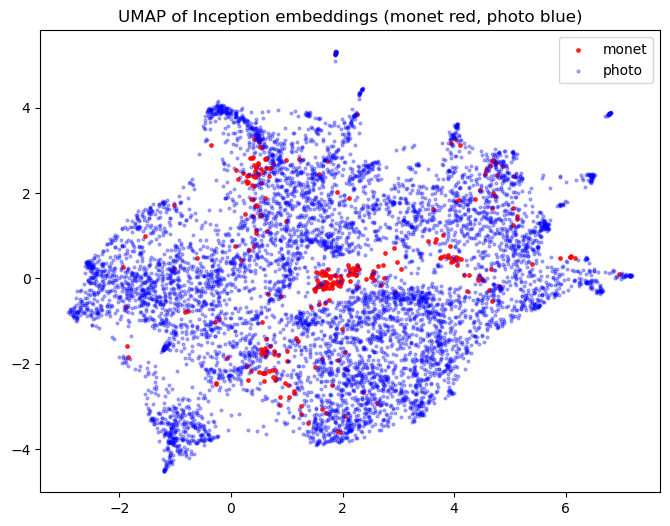

In [31]:
# UMAP for visualization (subset if very large)
all_emb = np.vstack([emb_monet, emb_photo])
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj = reducer.fit_transform(all_emb)
n_m = emb_monet.shape[0]
plt.figure(figsize=(8,6))
plt.scatter(proj[:n_m,0], proj[:n_m,1], c='red', label='monet', s=6, alpha=0.8)
plt.scatter(proj[n_m:,0], proj[n_m:,1], c='blue', label='photo', s=4, alpha=0.3)
plt.legend()
plt.title("UMAP of Inception embeddings (monet red, photo blue)")
plt.savefig(os.path.join(out_dir, "umap_monet_photo.png"), dpi=200)
print("Wrote umap_monet_photo.png")
print("Done. FID:", fid_photomonet, "epsilon:", epsilon)

## How to interpret

### High-level summary
- FID = 118.099 is high. This means the photo distribution is far from the real Monet distribution in Inception feature space. To convert photos into convincing Monet-style paintings, the selected model will have to perform a substantial domain shift.
- The suggested ε = 0.139 is small: using it as a neighborhood radius around Monet embeddings, almost none of the photos already lie inside the Monet manifold. In other words, very few photos are inherently "Monet-like."
- UMAP (red = Monet, blue = photos) shows Monet points as small clusters inside a much larger photo cloud, consistent with Monet being a relatively narrow subset of visual styles/content compared to the variety in the photos.


### Number analysis
- `monet_nn_pct_5 = 0.139`: ε from Monet self-density (5th percentile). This says Monet paintings have some tight local neighborhoods at cosine distance <= 0.139.
- `photo_min_to_monet_pct_5 = 0.199`: the 5th percentile of the nearest Monet distance for photos is 0.199. Because 0.199 > ε, fewer than 5% of photos are within ε of any Monet painting. So under that Monet-local radius, almost no photos are already close.
- `photo_min_to_monet_pct_50 = 0.264`: the typical photo (median) is at cosine ~= 0.264 from the nearest Monet embedding: a non-trivial gap to close.
- `monet_nn_pct_100 = 0.365`: Monet embeddings cover some range (they are not single-point identical), but still their spread is limited relative to the overall photo cloud.

Interpretation: the photos are mostly NOT in the Monet feature regions. To generate Monet-like outputs, I will likely need strong style-transformation capacity, or filter / pre-process photos to those more similar to Monet.


### Implications for modeling and pipeline design
1. Amount of transformation required
   - Large average distances -> the generator must make large changes in color/texture and possibly higher-level composition to reach Monet modes.
2. Coverage & training signal
   - Low photo -> Monet coverage implies there are relatively few natural photo examples close to Monet to guide the model; the generator might struggle to learn mappings for the many photo regions far from Monet.
3. Danger of failure modes
   - If training pairs or adversarial setup assume small domain shifts, model may produce artifacts or fail to converge.
   - The Monet dataset is small, the model may overfit those Monet modes and not generalize to diverse photos.


# Model architecture 


## Design goals
- Preserve photo content while changing style to Monet.
- Use unpaired training (CycleGAN) because this project do not have aligned photo -> Monet pairs.
- Use the feature-space CSV to bootstrap training (warm-start subset + pseudo-pairs) and to evaluate coverage/FID during training.


## Architecture overview 
- Two generators:
  - G_A2B: Photo -> Monet
  - G_B2A: Monet -> Photo
- Two discriminators:
  - D_A: discriminates real photo vs fake photo
  - D_B: discriminates real Monet vs fake Monet
- Core losses:
  - Adversarial (LSGAN preferred)
  - Cycle-consistency L1 (A -> B -> A and B -> A -> B)
  - Identity loss (to help preserve colors/content)


## Generator 
- Base: ResNet generator
  - Input / output: 3 × H × W (RGB), scaled to [-1, 1]
  - Architecture:
    - Reflection padding 3
    - Conv 7×7, 64 filters, stride 1, InstanceNorm, ReLU
    - Conv 3×3, 128 filters, stride 2, InstanceNorm, ReLU
    - Conv 3×3, 256 filters, stride 2, InstanceNorm, ReLU
    - N residual blocks (N = 9 for 256×256; N = 6 for 128×128), each:
      - ReflectionPad 1
      - Conv 3×3, 256, InstanceNorm, ReLU
      - ReflectionPad 1
      - Conv 3×3, 256, InstanceNorm
      - Add skip connection
    - Upsample (transpose conv or resize + conv):
      - ConvTranspose 3×3, 128, stride 2, InstanceNorm, ReLU (or resize -> conv)
      - ConvTranspose 3×3, 64, stride 2, InstanceNorm, ReLU
    - Conv 7×7, 3 filters, stride 1, tanh activation
  - Normalization: InstanceNorm 
  - Upsampling: Prefer resize -> conv (bilinear resize then conv) to avoid checkerboard artifacts.
  - Activation: ReLU in intermediate layers; tanh at output.

Reason
- Residual blocks preserve high-level structure while allowing flexible style transforms.
- InstanceNorm helps remove instance-level contrast variations and stabilizes style transfer.
- Reflection padding reduces border artifacts in stylized images.


## Discriminator 
- PatchGAN discriminator (70×70 receptive field)
  - Series of conv layers with stride 2 to downsample, LeakyReLU activations, no normalization on first layer, InstanceNorm or SpectralNorm on later layers.
  - Last layer outputs a 30×30 map of real/fake scores.
- Use LSGAN (least-squares adversarial) loss. It helps stability, reduces vanilla GAN instability.

Reason
- Classifies patches rather than the whole image. It forces realistic local texture/brushstroke patterns without over-emphasizing global shape.


## Losses and weights
- Adversarial loss (LSGAN) for both directions:
  - L_GAN(G_A2B, D_B) + L_GAN(G_B2A, D_A)
- Cycle-consistency loss:
  - L_cycle = lambda_cycle * (||G_B2A(G_A2B(A)) - A||_1 + ||G_A2B(G_B2A(B)) - B||_1)
  - lambda_cycle = 10.0 (classic choice)
- Identity loss:
  - L_id = lambda_id * (||G_A2B(B) - B||_1 + ||G_B2A(A) - A||_1)
  - lambda_id = 0.5 * lambda_cycle (or lambda_id = 5 if using lambda_cycle=10)


## Hyperparameters 
- Input size: 256 × 256 
- Batch size: 1 – 4 
- Optimizer: Adam(lr=2e-4, beta1=0.5, beta2=0.999)
- Learning rate schedule:
  - Keep lr constant for first 100 epochs, linearly decay to 0 over next 100 epochs (total 200)
  - For faster experimentation, use 50+50 or 50+50 schedule
- Epochs: 100–20
- Replay buffer (image pool) size: 50 for discriminator training
- Checkpointing: save every N epochs, and generate validation images to evaluate.

## Using feature-space CSV from EDA 
1. Warm-start subset:
   - Select photos with small `min_monet_nn`.
   - Create a warm-start TFRecord containing only these photos to initialize training.
   - Rationale: these examples need a smaller style shift and are helpful for early generator stability.

2. Pseudo-pairs (aux supervision):
   - For each photo row, use the `nearest_monet` index/path from EDA as a pseudo-target.
   - Apply a low-weight perceptual (VGG) or L1 loss between G_A2B(photo) and the nearest Monet. Use only in early epochs or with a low weight to avoid overfitting to the single nearest Monet sample.

3. Curriculum training:
   - Stage 1: train on warm-start subset + full Monet set
   - Stage 2: gradually add more photos in distance-percentile increments.

4. Clustering / per-cluster strategies:
   - Cluster photo embeddings; compute per-cluster FID (mFID). If a cluster is particularly far/hard, either delay adding it to training or use cluster-conditioned generator.

5. Evaluation loop:
   - Use the same Inception preprocessing used for in EDA scripts to compute embeddings of generated outputs.
   - Monitor FID, coverage@ε (using ε from Monet self-NN), mean/std of photo->Monet distances, and per-cluster mFID. 




# CycleGAN Results & Analysis

## Model sizes (parameter counts)
- G_AB params: 7,841,411
- G_BA params: 7,841,411
- D_A params: 2,765,633
- D_B params: 2,765,633

Training mode: from scratch  
Total iterations: 20,000

## Loss timeline 
(Values reported as "g = <generator_loss> d = <discriminator_loss>")

- Iter 1: g=24.5747 d=4.6026
- Iter 50: g=11.2798 d=1.6058
- Iter 500: g=9.8646 d=0.8153
- Iter 1,000: g=8.0431 d=1.0930
- Iter 2,000: g=8.9538 d=0.5808   (ckpt-1)
- Iter 4,000: g=8.6394 d=0.3567   (ckpt-2)
- Iter 6,000: g=8.8478 d=0.4496   (ckpt-3)
- Iter 8,000: g=7.9137 d=0.2851   (ckpt-4)
- Iter 10,000: g=7.6024 d=0.5146  (ckpt-5)
- Iter 12,000: g=7.6968 d=0.3696  (ckpt-6)
- Iter 14,000: g=6.5725 d=0.4407  (ckpt-7)
- Iter 16,000: g=6.6844 d=0.4790  (ckpt-8)
- Iter 18,000: g=5.8064 d=0.0799  (ckpt-9)
- Iter 20,000: g=7.0748 d=0.1815  (ckpt-10, final)

### Observations:
- Generator loss started high (~24.6) and dropped quickly in early iterations to the 6–12 range, then stabilized mostly between ≈5 and 9 with intermittent spikes.
- Discriminator loss started high (~4.6) then rapidly decreased and remained mostly low, often below 1.0 and sometimes approaching ~0.08 (very low).
- Several generator spikes are visible (e.g., ~14.95 at iter 100; ~14.67 at iter 900; others), but overall the generator has lower mean loss later in training.
- The discriminator loss frequently falls below 0.5 and occasionally near 0.1 or less, indicating the discriminator often outputs confident predictions.

---

## Interpretation

### 1. Convergence behavior
   - The generator loss converged from very high to a moderate, fluctuating plateau. That is typical in GAN training where losses alone don't fully indicate visual quality.
   - The discriminator is often very confident (low loss). Extremely low discriminator loss can indicate the discriminator became too strong at times, which may hinder generator progress or cause instability. However, the generator continued to improve intermittently.

### 2. Stability
   - Training appears reasonably stable overall: repeated checkpoints were saved and no obvious run termination occurred. 
   - Intermittent spikes in generator loss are expected. No sustained runaway behavior is visible.

### 3. Thought
   - For image-to-image GANs like CycleGAN, perceptual/visual quality and metrics (FID, LPIPS) matter more than raw loss values.

## Summary
- Training completed 20k iterations in ~379.5 minutes. Checkpoints saved every ~2k iterations (10 total).
- Generator stabilized with moderate loss values; discriminator loss is often very low, indicating it was frequently confident.
